In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Config')
from lablib import *

# Funzioni utili

In [180]:
def dms_to_dd(d, m, s):
    dd = d + float(m)/60 + float(s)/3600
    return dd

def minima_dev_prisma(deg, alfa):
    '''
    Calcola n dato l'angolo di incidenza e l'angolo di deviazione
    '''
    return np.sin(np.radians(deg + alfa)/2) / np.sin(np.radians(alfa/2))

def minima_dev_prisma_err(deg, alfa, deg_err, alfa_err):
    rad = np.radians(deg)
    alfa_rad = np.radians(alfa)
    rad_err = np.radians(deg_err)
    alfa_rad_err = np.radians(alfa_err)
    
    return (np.sqrt((np.sin(alfa_rad/2)*np.cos((alfa_rad+rad)/2)*rad_err)**2+(np.sin(rad/2)*alfa_rad_err)**2))/np.abs(np.cos(alfa_rad)-1) 

def cauchy(x, a, b):
    return a + (b) / (x**2)

def cauchy_ignoto(n, a, b):
    return np.sqrt(b/(n-a))

def cauchy_ignoto_err(n, a, b, n_err, a_err, b_err, cov_ab):
    return np.sqrt(b*(a_err/(2*(n-a)))**2 + (b_err/2)**2/b + b*(n_err/(2*(n-a)))**2 + cov_ab/2)/(np.sqrt(n-a))

# CARATTERIZZAZIONE DEL PRISMA

## Mercurio
Incertezza/scala ver = 1' \
primo angolo riflesso = 285° 11' \
secondo angolo riflesso = 166° 6' \
alfa = 60 °

In [189]:
#import dati dal file PrismaAngoloMinimo

angolo_minimo_prisma = pd.read_excel("PrismaAngoloMinimo.xlsx")

deg_giallo_prisma_list = angolo_minimo_prisma["gradi giallo"]
primi_giallo_prisma_list = angolo_minimo_prisma["primi giallo"]
deg_ciano_prisma_list = angolo_minimo_prisma["gradi ciano"]
primi_ciano_prisma_list = angolo_minimo_prisma["primi ciano"]
deg_blu_prisma_list = angolo_minimo_prisma["gradi blu"]
primi_blu_prisma_list = angolo_minimo_prisma["primi blu"]
deg_viola_prisma_list = angolo_minimo_prisma["gradi viola"]
primi_viola_prisma_list = angolo_minimo_prisma["primi viola"]

#Calcolo media e errore standard media
deg_giallo_prisma = np.mean(deg_giallo_prisma_list)
primi_giallo_prisma = np.mean(primi_giallo_prisma_list)
deg_ciano_prisma = np.mean(deg_ciano_prisma_list)
primi_ciano_prisma = np.mean(primi_ciano_prisma_list)
deg_blu_prisma = np.mean(deg_blu_prisma_list)
primi_blu_prisma = np.mean(primi_blu_prisma_list)
deg_viola_prisma = np.mean(deg_viola_prisma_list)
primi_viola_prisma = np.mean(primi_viola_prisma_list)

#Calcolo le misure in gradi decimali
deg_giallo_prisma = dms_to_dd(deg_giallo_prisma, primi_giallo_prisma, 0)
deg_ciano_prisma = dms_to_dd(deg_ciano_prisma, primi_ciano_prisma, 0)
deg_blu_prisma = dms_to_dd(deg_blu_prisma, primi_blu_prisma, 0)
deg_viola_prisma = dms_to_dd(deg_viola_prisma, primi_viola_prisma, 0)

#Errore sulle misure in gradi (è dovuto solo all'errore sui primi)
err_giallo_prisma = np.std(primi_giallo_prisma_list, ddof=1)/np.sqrt(len(primi_giallo_prisma_list))
err_ciano_prisma = np.std(primi_ciano_prisma_list, ddof=1)/np.sqrt(len(primi_ciano_prisma_list))
err_blu_prisma = np.std(primi_blu_prisma_list, ddof=1)/np.sqrt(len(primi_blu_prisma_list))
err_viola_prisma = np.std(primi_viola_prisma_list, ddof=1)/np.sqrt(len(primi_viola_prisma_list))

0.5734883511361751 0.5174724898753341 0.5811865258054231 0.24944382578492943


In [210]:
deg_giallo_decimal_list = [dms_to_dd(i, j, 0) for i, j in zip(deg_giallo_prisma_list, primi_giallo_prisma_list)]
print(deg_giallo_decimal)

deg_giallo_decimal = np.mean(deg_giallo_decimal_list)
err_giallo_corrected = np.std(deg_giallo_decimal_list, ddof=1)/np.sqrt(len(deg_giallo_decimal_list))
print(err_giallo_corrected)

48.04666666666667
0.009558139185603283


In [182]:
#Calcolo di n per le varie lunghezze d'onda
#minima_dev_prisma calcola n trasponendo le misure in radianti

alfa = 60

n_giallo_prisma = minima_dev_prisma(deg_giallo_prisma, alfa)
n_ciano_prisma = minima_dev_prisma(deg_ciano_prisma, alfa)
n_blu_prisma = minima_dev_prisma(deg_blu_prisma, alfa)
n_viola_prisma = minima_dev_prisma(deg_viola_prisma, alfa)

err_n_giallo_prisma = minima_dev_prisma_err(deg_giallo_prisma, alfa, err_giallo_prisma, 0)
err_n_ciano_prisma = minima_dev_prisma_err(deg_ciano_prisma, alfa, err_ciano_prisma, 0)
err_n_blu_prisma = minima_dev_prisma_err(deg_blu_prisma, alfa, err_blu_prisma, 0)
err_n_viola_prisma = minima_dev_prisma_err(deg_viola_prisma, alfa, err_viola_prisma, 0)

print(f"Indice di rifrazione per il giallo: {n_giallo_prisma:.4g} ± {err_n_giallo_prisma:.1g}")
print(f"Indice di rifrazione per il ciano: {n_ciano_prisma:.4g} ± {err_n_ciano_prisma:.1g}")
print(f"Indice di rifrazione per il blu: {n_blu_prisma:.4g} ± {err_n_blu_prisma:.1g}")
print(f"Indice di rifrazione per il viola: {n_viola_prisma:.4g} ± {err_n_viola_prisma:.1g}")

Indice di rifrazione per il giallo: 1.619 ± 0.006
Indice di rifrazione per il ciano: 1.629 ± 0.005
Indice di rifrazione per il blu: 1.639 ± 0.006
Indice di rifrazione per il viola: 1.648 ± 0.002


In [183]:
#Interpolazione di lambda e n ottenuti con la formula di Cauchy
lambda_giallo = 579.0663*10**(-9)
lambda_ciano = 435.8328*10**(-9)
lambda_blu = 404.6563*10**(-9)
lambda_viola = 365.0153*10**(-9)

lambda_ = [lambda_giallo, lambda_ciano, lambda_blu, lambda_viola]
n = [n_giallo_prisma, n_ciano_prisma, n_blu_prisma, n_viola_prisma]
err_n = [err_n_giallo_prisma, err_n_ciano_prisma, err_n_blu_prisma, err_n_viola_prisma]

pars1, vals1, ers1, *other1 = LS_fit(lambda_, n, err_n, cauchy, a = 1, b = 1)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.6491 (χ²/ndof = 0.3)     │              Nfcn = 131              │
│ EDM = 1.91e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.596   │   0.009   │            │            │         │         │       │
│ 1 │ b    │  7.0e-15  │  1.3e-15  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────────┐
│   │                     a                     b │
├───┼─────────────────────────────────────────────┤
│ a │              7.68e-05 -11.1732928064388e-18 │
│ b │ -11.1732928064388e-18              1.71e-30 │
└───┴─────────────────────────────────────────────┘

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\franc\AppData\Local\Temp\ipykernel_16760\1699530716.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$ [nm]")


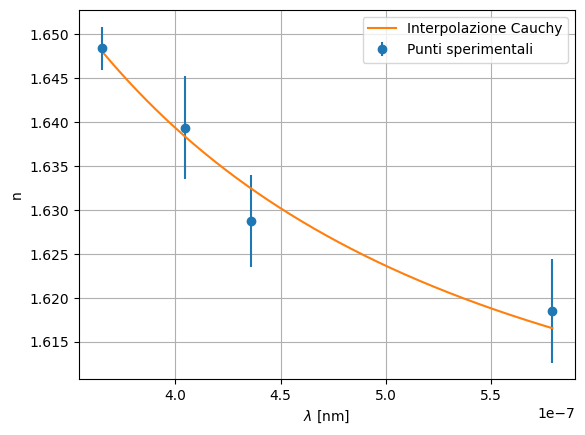

In [184]:
#Plot dei punti sperimentali e della curva interpolante
plt.errorbar(lambda_, n, yerr=err_n, fmt='o', label="Punti sperimentali")
x = np.linspace(lambda_viola,lambda_giallo,  1000)
y = cauchy(x, *vals1)
plt.plot(x, y, label="Interpolazione Cauchy")
plt.xlabel("$\lambda$ [nm]")
plt.ylabel("n")
plt.legend()
plt.grid()
plt.show()

## Gas ignoto
Sottrarre angoli di 180° 

In [188]:
#Import dei dati dal file GasIgnoto.xlsx

gas_ingnoto = pd.read_excel("GasIgnoto.xlsx")

deg_rosso_gas_prisma_list = gas_ingnoto["gradi rosso"] - 180
primi_rosso_gas_prisma_list = gas_ingnoto["primi rosso"]
deg_giallo_gas_prisma_list = gas_ingnoto["gradi giallo"] -180
primi_giallo_gas_prisma_list = gas_ingnoto["primi giallo"]
deg_verde_gas_prisma_list = gas_ingnoto["gradi verde"] -180
primi_verde_gas_prisma_list = gas_ingnoto["primi verde"]
deg_viola_gas_prisma_list = gas_ingnoto["gradi viola"] -180
primi_viola_gas_prisma_list = gas_ingnoto["primi viola"]

#Calcolo media e errore standard media
deg_rosso_gas_prisma = np.mean(deg_rosso_gas_prisma_list)
primi_rosso_gas_prisma = np.mean(primi_rosso_gas_prisma_list)
deg_giallo_gas_prisma = np.mean(deg_giallo_gas_prisma_list)
primi_giallo_gas_prisma = np.mean(primi_giallo_gas_prisma_list)
deg_verde_gas_prisma = np.mean(deg_verde_gas_prisma_list)
primi_verde_gas_prisma = np.mean(primi_verde_gas_prisma_list)
deg_viola_gas_prisma = np.mean(deg_viola_gas_prisma_list)
primi_viola_gas_prisma = np.mean(primi_viola_gas_prisma_list)

#Errore sulle misure in gradi (è dovuto solo all'errore sui primi)
err_rosso_gas_prisma = np.std(primi_rosso_gas_prisma_list, ddof=1)/np.sqrt(len(primi_rosso_gas_prisma_list))
err_giallo_gas_prisma = np.std(primi_giallo_gas_prisma_list, ddof=1)/np.sqrt(len(primi_giallo_gas_prisma_list))
err_verde_gas_prisma = np.std(primi_verde_gas_prisma_list, ddof=1)/np.sqrt(len(primi_verde_gas_prisma_list))
err_viola_gas_prisma = np.std(primi_viola_gas_prisma_list, ddof=1)/np.sqrt(len(primi_viola_gas_prisma_list))

#Calcolo le misure in gradi decimali
deg_rosso_gas_prisma = dms_to_dd(deg_rosso_gas_prisma, primi_rosso_gas_prisma, 0)
deg_giallo_gas_prisma = dms_to_dd(deg_giallo_gas_prisma, primi_giallo_gas_prisma, 0)
deg_verde_gas_prisma = dms_to_dd(deg_verde_gas_prisma, primi_verde_gas_prisma, 0)
deg_viola_gas_prisma = dms_to_dd(deg_viola_gas_prisma, primi_viola_gas_prisma, 0)

In [186]:
#calcolo di n per le varie lunghezze d'onda
#minima_dev_prisma calcola n trasponendo le misure in radianti

alfa = 60

n_rosso_gas_prisma = minima_dev_prisma(deg_rosso_gas_prisma, alfa)
n_giallo_gas_prisma = minima_dev_prisma(deg_giallo_gas_prisma, alfa)
n_verde_gas_prisma = minima_dev_prisma(deg_verde_gas_prisma, alfa)
n_viola_gas_prisma = minima_dev_prisma(deg_viola_gas_prisma, alfa)

err_n_rosso_gas_prisma = minima_dev_prisma_err(deg_rosso_gas_prisma, alfa, err_rosso_gas_prisma, 0)
err_n_giallo_gas_prisma = minima_dev_prisma_err(deg_giallo_gas_prisma, alfa, err_giallo_gas_prisma, 0)
err_n_verde_gas_prisma = minima_dev_prisma_err(deg_verde_gas_prisma, alfa, err_verde_gas_prisma, 0)
err_n_viola_gas_prisma = minima_dev_prisma_err(deg_viola_gas_prisma, alfa, err_viola_gas_prisma, 0)

#calcolo di lambda per il gas ignoto
lambda_rosso = cauchy_ignoto(n_rosso_gas_prisma, *vals1)
lambda_giallo = cauchy_ignoto(n_giallo_gas_prisma, *vals1)
lambda_verde = cauchy_ignoto(n_verde_gas_prisma, *vals1)
lambda_viola = cauchy_ignoto(n_viola_gas_prisma, *vals1)

#other1[3] contiene la matrice di covarianza, aggiungendo [0][1] è la covarianza tra a e b
err_lambda_rosso = cauchy_ignoto_err(n_rosso_gas_prisma, *vals1, err_n_rosso_gas_prisma, *ers1, other1[3][0][1])
err_lambda_giallo = cauchy_ignoto_err(n_giallo_gas_prisma, *vals1, err_n_giallo_gas_prisma, *ers1, other1[3][0][1])
err_lambda_verde = cauchy_ignoto_err(n_verde_gas_prisma, *vals1, err_n_verde_gas_prisma, *ers1, other1[3][0][1])
err_lambda_viola = cauchy_ignoto_err(n_viola_gas_prisma, *vals1, err_n_viola_gas_prisma, *ers1, other1[3][0][1])

#stampa dei risultati
print(f"Indice di rifrazione per il rosso: {n_rosso_gas_prisma:.4g} ± {err_n_rosso_gas_prisma:.1g}")
print(f"Indice di rifrazione per il giallo: {n_giallo_gas_prisma:.4g} ± {err_n_giallo_gas_prisma:.1g}")
print(f"Indice di rifrazione per il verde: {n_verde_gas_prisma:.4g} ± {err_n_verde_gas_prisma:.1g}")
print(f"Indice di rifrazione per il viola: {n_viola_gas_prisma:.4g} ± {err_n_viola_gas_prisma:.1g}")

print(f"Lambda per il rosso: {lambda_rosso*10**9:.1f} ± {err_lambda_rosso*10**9:.1f} nm")
print(f"Lambda per il giallo: {lambda_giallo*10**9:.1f} ± {err_lambda_giallo*10**9:.1f} nm")
print(f"Lambda per il verde: {lambda_verde*10**9:.1f} ± {err_lambda_verde*10**9:.1f} nm")
print(f"Lambda per il viola: {lambda_viola*10**9:.1f} ± {err_lambda_viola*10**9:.1f} nm")

Indice di rifrazione per il rosso: 1.619 ± 0.004
Indice di rifrazione per il giallo: 1.619 ± 0.008
Indice di rifrazione per il verde: 1.629 ± 0.006
Indice di rifrazione per il viola: 1.639 ± 0.005
Lambda per il rosso: 553.5 ± 126.3 nm
Lambda per il giallo: 543.4 ± 141.4 nm
Lambda per il verde: 457.7 ± 83.3 nm
Lambda per il viola: 401.7 ± 60.0 nm


# RETICOLO

## Doppietto sodio
Misurata una sola riga, quella più vicina al centro \
300 linee al millimetro